
---


# Optimization & Simulation: Final Project


---


## 1. Study Case: Allocation of courses & happiness


---


Find the best allocation of course to faculty while maximing their happiness (preference) for ABC School of Business.



---


### 1.1. Optimization for allocation of courses & happiness

---


* The Dean would like to maximize the happiness level of faculty members
* Preference rating on a 0 - 5 scale
* Within the preference rating, 0 indicates the faculty cannot teach the course.
* The university follows trimester system (three trimesters in an academic year).
* University's policy related to faculty workload established that a faculty worload in a trimester should not exceed 6 credits.
* University's policy related to faculty workload established that a faculty worload in an academic year should be between 10 and 16 credits.

* **Sets**   
    * ***M*** : Set of courses (each courses is ***i***)
    * ***N*** : Set of faculties members (each faculty is ***j***)
    * ***T*** : Set of trimesters (each trimester ***t***)

* **Parameters**    
    * ***p_ij*** : Faculty's preference of course
    * ***q_i*** : Courses's credits.     
    * ***g_i*** : Number of groups for course i
    * ***s_i*** : Trimester in which course i is offered   

* **Decision variables**           
    * ***X_ij***: Number of groups of course i assigned to faculty j. Integer variable.


* **Objective Function**     
    * Max Z = ∑∑ p_ij* X_ij    

* **Constraints**     
    * Each group of a course is assigned to exactly one faculty     
      * X_ij = g_i Vi∈M     

    * Each faculty trimestral max capacity must be respected (max amount of credits per trimester)      
      * ∑qi * Xij ≤ 6  Vj∈Nt∈T
        * Vj∈Nt∈T     
             
    * Each faculty annual max capacity must be respected (max amount of credits per academic year)      
      * ∑∑qi * Xij ≤ 16  Vj∈Nt∈T     

    * Each faculty annual min capacity must be accomplished (min amount of credits per academic year)       
      * ∑∑qi * Xij ≥ 10  Vj∈Nt∈T    
    * Courses can not be allocated where the faculty preference is 0       
      * Xij ≥ 0 Vi∈Mj∈N where pij > 0  

  * Define that the defined Decision variables have to be binary
    * X_ij∈ ≥ 0 and integer Vi∈Mj∈N

   

---


### 1.2. Simulation for allocation of course & happiness

---


In real-world problems, there is always uncertainty. This is relate to issue that whoever addresses a problem, does not have complete control or power over all variables. To deal with such uncertainties, we can use simulation to evaluate potential scenarios affected by them.    

In this case, the amount of students per course is an uncertity variable. While the ABS School of business has a minimum of groups and a maximum, it is known how many students, and therefore groups, will actually take place in each academic semester.   

---

### 1.3. Coding clarifications

---


To centralice the information of the sets of faculty and courses, a excel spreadsheet will be used, provided by a faculty teacher. However, to work more confortably the table will be breakdown to be store into variables. Moreover, for the dfset to be easily access through the Google Colab file, the excel spreadsheet will be store online in a github repository under r41ss4 account, one of the copyrights owner of this script.

Moreover, the probability within the simulation is decreasing, as probability within min and max groups was not specify and Universities tent to manage margins, where there is a minimum of students needed to open a new group. Otherwise, the university might just expand the original group to avoid having to allocate a teacher to the new group, and increase their expense of teacher's hours per group. However, this is one of the main limitations consider at the end of the project.



---


## 2. Optimization & Simulation Processing


---



In [ ]:
# Install pulp
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 23.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from pulp import *
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import seaborn as sns

In [ ]:
# Read df of products
df = pd.read_excel('https://raw.githubusercontent.com/r41ss4/rennes_os/refs/heads/main/case_abc.xlsx')
df.head(5)

,Course Code,Course Name,Credits,Trimester,Min Nb Groups,Max Nb Groups,Faculty 1,Faculty 2,Faculty 3,Faculty 4,Faculty 5,Faculty 6,Faculty 7,Faculty 8,Faculty 9,Faculty 10,Faculty 11,Faculty 12
0,T101,Operations Management,3,1,1,1,0,5,2,0,5,4,3,0,3,5,2,2
1,T102,Data-Driven Decision Making,2,1,1,3,1,5,4,5,5,1,4,0,0,5,0,5
2,T103,Service Operations,2,1,1,1,1,0,4,1,3,0,3,1,3,4,2,5
3,T104,Project Management,2,1,2,2,2,2,0,0,1,4,0,5,2,1,1,5
4,T105,Simulation and System Dynamics,2,1,3,3,4,3,0,4,3,1,0,0,2,5,1,0


In [ ]:
# Define the model
abc = LpProblem("Allocation", LpMaximize)

In [ ]:
# Sets
M = df['Course Code'].unique()
N = [f'Faculty {i}' for i in range(1, 13)]
T = [1, 2, 3]

In [ ]:
# Decision variables
X_ij = LpVariable.dicts("X", ((i, j) for i in M for j in N), lowBound=0, cat='Integer')

In [ ]:
# Parameters
# Preference of faculty
p_ij = df.set_index('Course Code')[N].to_dict(orient='index')
# Credits quantity
q_i = df.set_index('Course Code')['Credits'].to_dict()
# Group min
min_groups = df.set_index('Course Code')['Min Nb Groups'].to_dict()
# Group max
max_groups = df.set_index('Course Code')['Max Nb Groups'].to_dict()
# Course Trimester
s_i = df.set_index('Course Code')['Trimester'].to_dict()

In [ ]:
# Set a random seed  (so result is the same)
np.random.seed(1405)

In [ ]:
# Objective function
abc += lpSum(p_ij[i][j] * X_ij[i, j] for i in M for j in N)

In [ ]:
# Function to simulate the number of groups for each course
def simulate_groups(min_groups, max_groups):
    groups = {}
    for i in M:
        # Define the range of possible groups for course i
        possible_groups = np.arange(min_groups[i], max_groups[i] + 1)

        # Define custom probabilities (100% for min_groups, decreasing afterward)
        probabilities = np.linspace(1, 0, len(possible_groups))  # Linear decrease
        probabilities = probabilities / probabilities.sum()  # Normalize to sum to 1

        # Randomly select the number of groups based on custom probabilities
        groups[i] = np.random.choice(possible_groups, p=probabilities)

    return groups

In [ ]:
# Number of replicas
num_replicas = 1000

In [ ]:
# Run multiple simulations (replicas)
replica_results = []
for replica in range(num_replicas):
    print(f"\nReplica {replica + 1}:")
    g_i = simulate_groups(min_groups, max_groups)
    print("Simulated groups:", g_i)
    replica_results.append(g_i)  # Store the results for further analysis

# Example: Analyze the results
print("\nSummary of Replicas:")
for i, result in enumerate(replica_results):
    print(f"Replica {i + 1}: {result}")


Replica 1:
Simulated groups: {'T101': np.int64(1), 'T102': np.int64(1), 'T103': np.int64(1), 'T104': np.int64(2), 'T105': np.int64(3), 'T106': np.int64(1), 'T107': np.int64(1), 'T108': np.int64(1), 'T109': np.int64(2), 'T110': np.int64(1), 'T111': np.int64(1), 'T112': np.int64(2), 'T113': np.int64(1), 'T114': np.int64(1), 'T201': np.int64(1), 'T202': np.int64(1), 'T203': np.int64(2), 'T204': np.int64(1), 'T205': np.int64(1), 'T206': np.int64(1), 'T207': np.int64(3), 'T208': np.int64(1), 'T209': np.int64(1), 'T210': np.int64(2), 'T211': np.int64(1), 'T212': np.int64(1), 'T213': np.int64(1), 'T214': np.int64(1), 'T301': np.int64(1), 'T302': np.int64(2), 'T303': np.int64(1), 'T304': np.int64(1), 'T305': np.int64(1), 'T306': np.int64(2), 'T307': np.int64(1), 'T308': np.int64(2), 'T309': np.int64(1), 'T310': np.int64(1), 'T311': np.int64(3), 'T312': np.int64(1), 'T313': np.int64(1), 'T314': np.int64(2)}

Replica 2:
Simulated groups: {'T101': np.int64(1), 'T102': np.int64(1), 'T103': np.int

In [ ]:
# Parameter obtain by randomness as Number of groups
g_i = simulate_groups(min_groups, max_groups)

In [ ]:
g_i

{'T101': np.int64(1),
 'T102': np.int64(2),
 'T103': np.int64(1),
 'T104': np.int64(2),
 'T105': np.int64(3),
 'T106': np.int64(1),
 'T107': np.int64(1),
 'T108': np.int64(1),
 'T109': np.int64(2),
 'T110': np.int64(1),
 'T111': np.int64(1),
 'T112': np.int64(2),
 'T113': np.int64(1),
 'T114': np.int64(1),
 'T201': np.int64(1),
 'T202': np.int64(1),
 'T203': np.int64(1),
 'T204': np.int64(1),
 'T205': np.int64(1),
 'T206': np.int64(1),
 'T207': np.int64(3),
 'T208': np.int64(1),
 'T209': np.int64(1),
 'T210': np.int64(2),
 'T211': np.int64(1),
 'T212': np.int64(1),
 'T213': np.int64(1),
 'T214': np.int64(1),
 'T301': np.int64(1),
 'T302': np.int64(2),
 'T303': np.int64(1),
 'T304': np.int64(1),
 'T305': np.int64(2),
 'T306': np.int64(2),
 'T307': np.int64(1),
 'T308': np.int64(1),
 'T309': np.int64(1),
 'T310': np.int64(1),
 'T311': np.int64(3),
 'T312': np.int64(1),
 'T313': np.int64(1),
 'T314': np.int64(2)}

In [ ]:
# Constraints
for i in M:
    # Constrain_1: Each course's groups must be fully allocated
    abc += lpSum(X_ij[i, j] for j in N) == g_i[i]

for j in N:
    for t in T:
        # Constrain_2: Each faculty trimestral max capacity must be respected
        abc += lpSum(q_i[i] * X_ij[i, j] for i in M if s_i[i] == t) <= 6

    # Constrain_3: Each faculty annual max capacity must be respected
    abc += lpSum(q_i[i] * X_ij[i, j] for i in M) <= 16

    # Constrain_4: Each faculty annual min capacity must be respected
    abc += lpSum(q_i[i] * X_ij[i, j] for i in M) >= 10

for i in M:
    for j in N:
        # Constrain_5: Courses can not be allocated where the faculty preference is 0
        if p_ij[i][j] == 0:
            abc += X_ij[i, j] == 0

In [ ]:
# Solve the problem & status
status = abc.solve()
print(f"Solver status: {LpStatus[status]}")

# Calculate Max Z
max_z = 0
for i in M:
    for j in N:
        max_z += p_ij[i][j] * value(X_ij[i, j])

# Print Max Z
print(f"Max Z (Total Preference): {max_z}")

Solver status: Optimal
Max Z (Total Preference): 278.0


In [ ]:
# See courses, faculties and groups
for i in M:
    for j in N:
        if value(X_ij[i, j]) > 0:
            print(f"course {i} is assigned to Faculty {j} for {value(X_ij[i, j])} groups")

course T101 is assigned to Faculty Faculty 5 for 1.0 groups
course T102 is assigned to Faculty Faculty 2 for 1.0 groups
course T102 is assigned to Faculty Faculty 10 for 1.0 groups
course T103 is assigned to Faculty Faculty 12 for 1.0 groups
course T104 is assigned to Faculty Faculty 8 for 1.0 groups
course T104 is assigned to Faculty Faculty 12 for 1.0 groups
course T105 is assigned to Faculty Faculty 1 for 1.0 groups
course T105 is assigned to Faculty Faculty 10 for 2.0 groups
course T106 is assigned to Faculty Faculty 8 for 1.0 groups
course T107 is assigned to Faculty Faculty 1 for 1.0 groups
course T108 is assigned to Faculty Faculty 4 for 1.0 groups
course T109 is assigned to Faculty Faculty 11 for 2.0 groups
course T110 is assigned to Faculty Faculty 2 for 1.0 groups
course T111 is assigned to Faculty Faculty 3 for 1.0 groups
course T112 is assigned to Faculty Faculty 4 for 2.0 groups
course T113 is assigned to Faculty Faculty 5 for 1.0 groups
course T114 is assigned to Faculty 



---

## 3. Visualization of Results


---



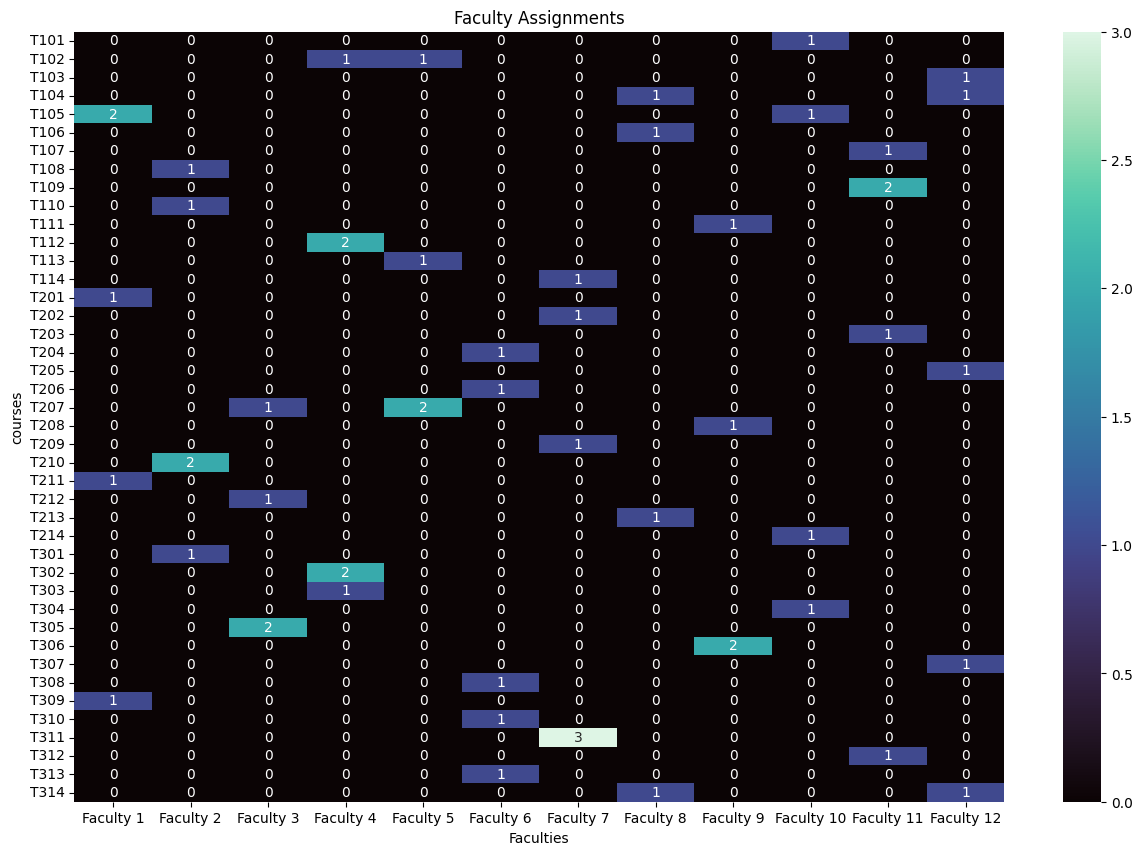

In [ ]:
# Create a matrix in heatmap style
assignment_matrix = pd.DataFrame(0, index=M, columns=N)
for i in M:
    for j in N:
        assignment_matrix.loc[i, j] = value(X_ij[i, j])

# Plot the heatmap
# Set the figure size
plt.figure(figsize=(15, 10))
sns.heatmap(assignment_matrix, annot=True, cmap="mako")
plt.title("Faculty Assignments")
plt.xlabel("Faculties")
plt.ylabel("courses")
plt.show()

In [ ]:
# Create a matrix to store credits per faculty per trimester
credits_matrix = pd.DataFrame(0, index=N, columns=T)

# Calculate credits for each faculty in each trimester
for j in N:
    for t in T:
        # Sum credits for all courses assigned to faculty j in trimester t
        credits_matrix.loc[j, t] = sum(q_i[i] * value(X_ij[i, j]) for i in M if s_i[i] == t)

# Add a column for total credits per faculty
credits_matrix['Total Credits'] = credits_matrix.sum(axis=1)

# Display the credits matrix
print("Credits per Faculty per Trimester (with Total Credits):")
print(credits_matrix)

Credits per Faculty per Trimester (with Total Credits):
            1  2  3  Total Credits
Faculty 1   4  4  2             10
Faculty 2   4  4  2             10
Faculty 3   0  6  4             10
Faculty 4   6  0  6             12
Faculty 5   4  6  0             10
Faculty 6   0  5  6             11
Faculty 7   2  6  6             14
Faculty 8   5  3  2             10
Faculty 9   3  3  4             10
Faculty 10  5  3  2             10
Faculty 11  6  3  2             11
Faculty 12  4  2  4             10


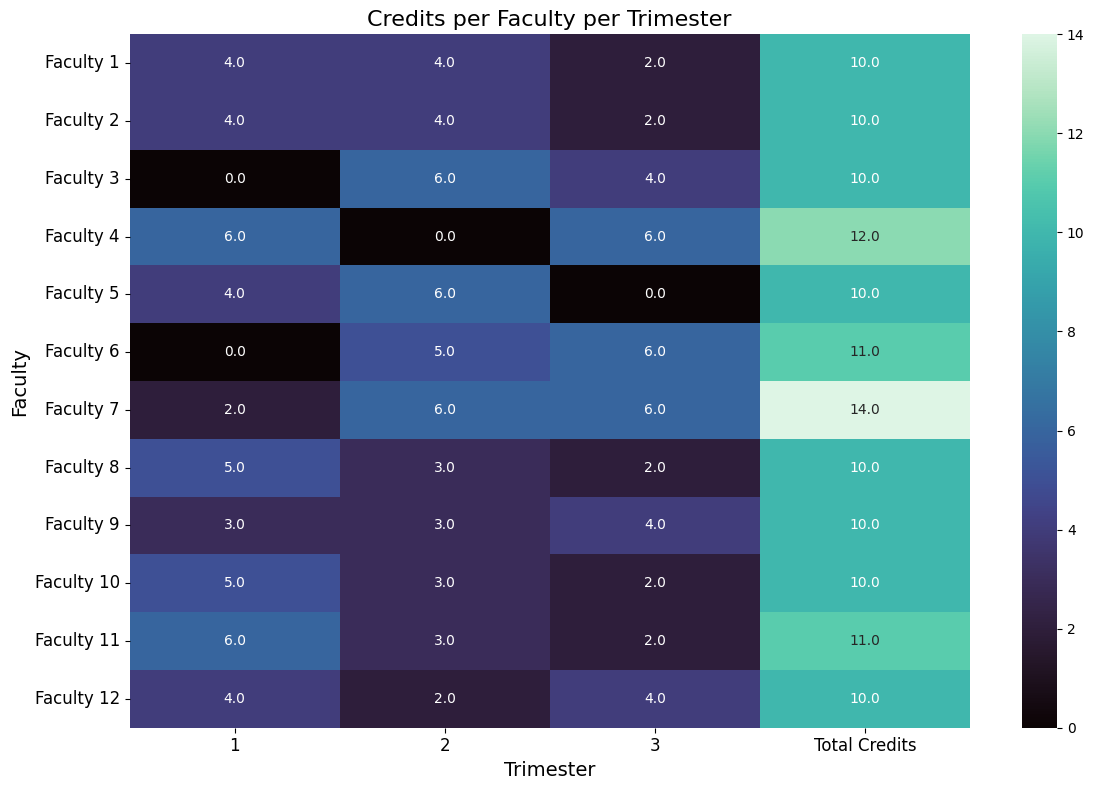

In [ ]:
# Plot the credits matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(credits_matrix, annot=True, cmap="mako", fmt=".1f")
plt.title("Credits per Faculty per Trimester", fontsize=16)
plt.xlabel("Trimester", fontsize=14)
plt.ylabel("Faculty", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Convert g_i into a DataFrame
df_gi = pd.DataFrame(list(g_i.items()), columns=['Course', 'Number of Groups'])

In [ ]:
# Add trimester information to the DataFrame
df_gi['Trimester'] = df_gi['Course'].map(s_i)
# Review
df_gi

,Course,Number of Groups,Trimester
0,T101,1,1
1,T102,2,1
2,T103,1,1
3,T104,2,1
4,T105,3,1
5,T106,1,1
6,T107,1,1
7,T108,1,1
8,T109,2,1
9,T110,1,1


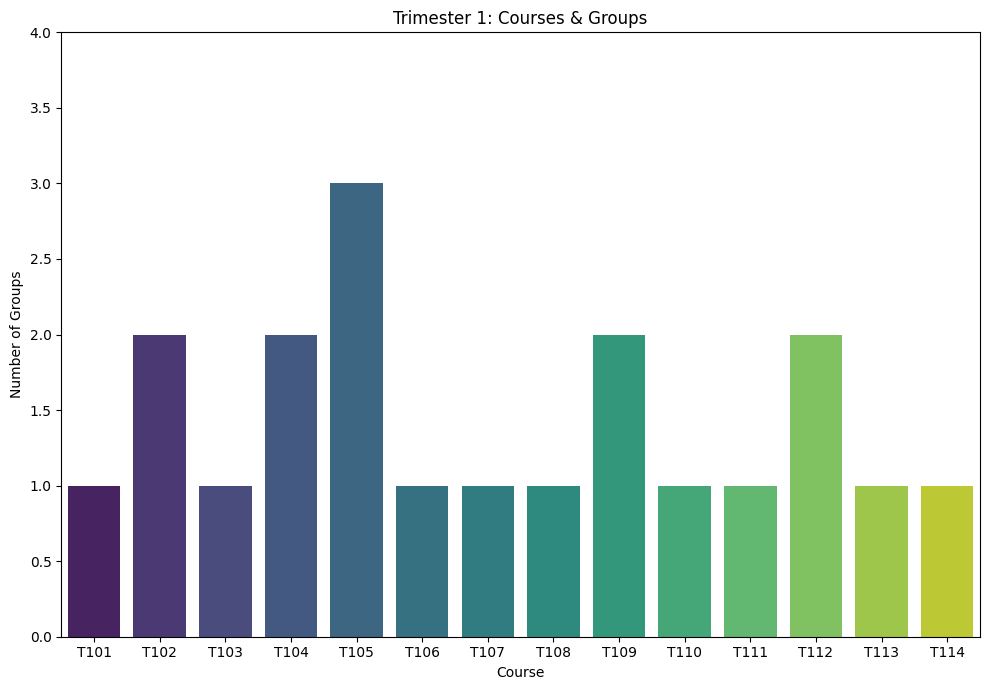

In [ ]:
# Plot for Trimester 1: Courses & Groups
plt.figure(figsize=(10, 7))
sns.barplot(x='Course', y='Number of Groups', data=df_gi[df_gi['Trimester'] == 1], palette='viridis', hue='Course')
plt.title("Trimester 1: Courses & Groups")
plt.xlabel("Course")
plt.ylabel("Number of Groups")
plt.ylim(0, max(max_groups.values()) + 1)
plt.tight_layout()
plt.show()

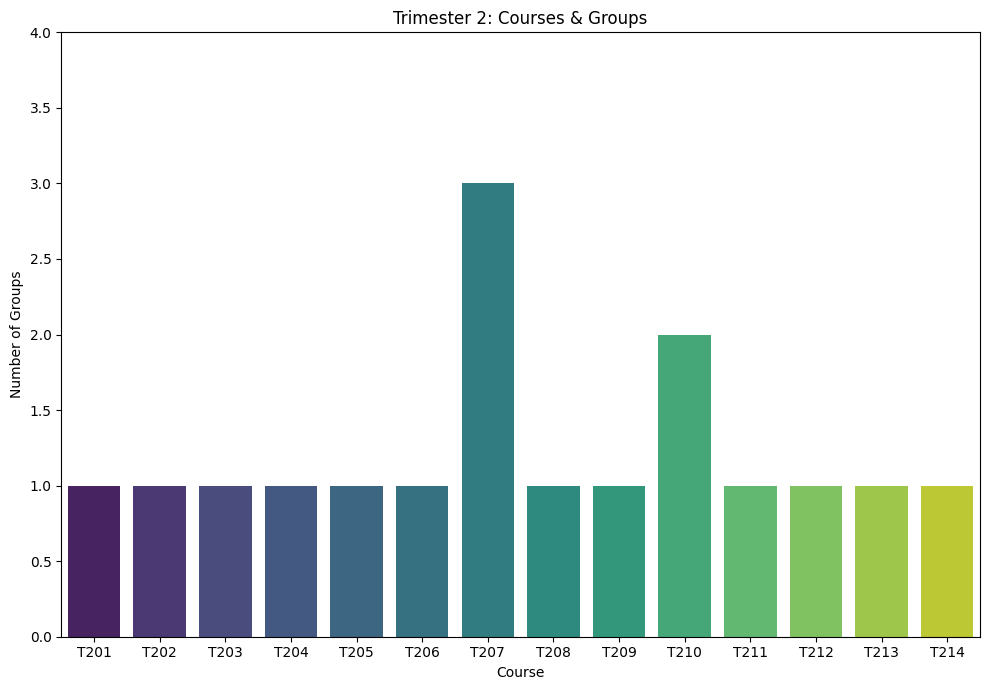

In [ ]:
# Plot for Trimester 2: Courses & Groups
plt.figure(figsize=(10, 7))
sns.barplot(x='Course', y='Number of Groups', data=df_gi[df_gi['Trimester'] == 2], palette='viridis', hue='Course')
plt.title("Trimester 2: Courses & Groups")
plt.xlabel("Course")
plt.ylabel("Number of Groups")
plt.ylim(0, max(max_groups.values()) + 1)
plt.tight_layout()
plt.show()

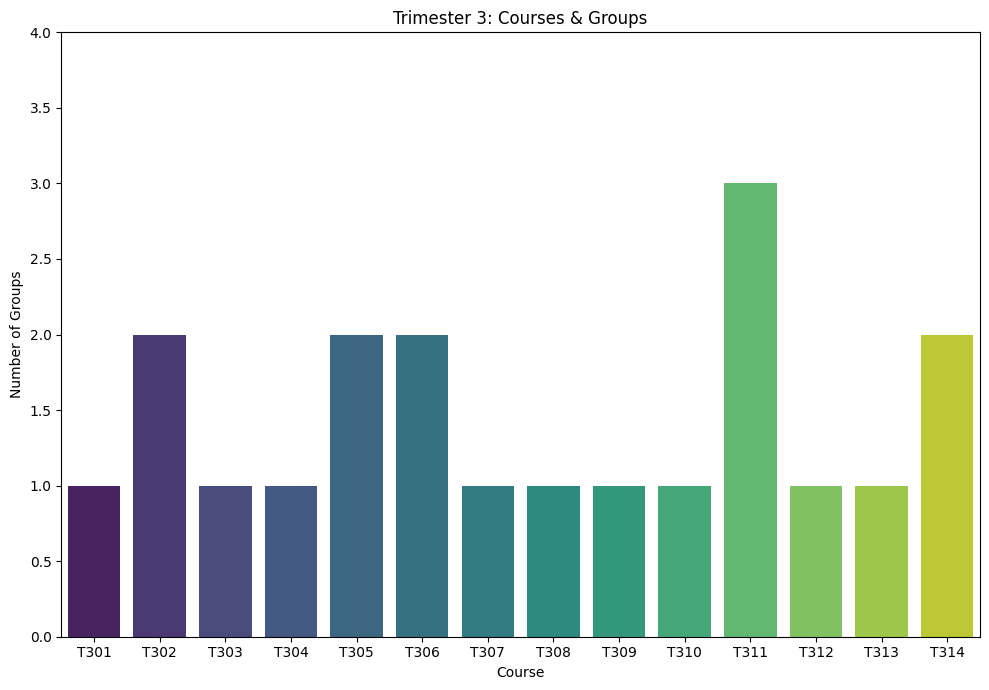

In [ ]:
# Plot for Trimester 2: Courses & Groups
plt.figure(figsize=(10, 7))
sns.barplot(x='Course', y='Number of Groups', data=df_gi[df_gi['Trimester'] == 3], palette='viridis', hue='Course')
plt.title("Trimester 3: Courses & Groups")
plt.xlabel("Course")
plt.ylabel("Number of Groups")
plt.ylim(0, max(max_groups.values()) + 1)
plt.tight_layout()
plt.show()


---

## 4. Final Thoughts

---


In the case, due to teh lack of information, it is assume that the probability between the minimum and maximum number of groups of each course decreases in each interval. However, this is not information provided by the ABC School of Business.

As they are starting to improve this type of process, the university should consider planning and collecting data to have more accurate information regarding this kind of matters, so that result are closer to the most probable real outcome, as not all courses might have similar probability within groups, some courses are probabily more popular in certain trimesters, etc.

Furthermore, the number of groups is consider, without details of the number of students, nor the min and max number of students per group. This difficults the manner to handle when a new group must be created, as there is probably a range where the faculty would rather enlarging a group than creating a extremly small new one to be touch by a faculty member.

With the proper information, it is possible to apply predictive analytics regarding the projection of groups per course in each trimester, incrementing accurary in optimization and simulation models for the faculties allocation of courses and groups.